In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
import cartopy
from shapely.geometry import point
import math

In [3]:
os.getcwd()

'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning'

In [4]:
#loading in the current enrollment for only the 2024-25 school year
current_enrollment = pd.read_csv(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\marketshare_output_pu_2324_848_gr_2021_2425_long.csv')
current_enrollment_2024 = current_enrollment[current_enrollment['year_str']=='2024-2025']
current_enrollment_2024.head()
current_enrollment_2024 = current_enrollment_2024.rename(columns = {'pu_2324_848':'pu_2324_84'})

In [5]:
#now we want to only show the 5th, 6th, 7th, and 8th grade - the grades that will be in high school in 2028-29
mask = current_enrollment_2024['grade'].isin([5,6,7,8])
hs_2028 = current_enrollment_2024[mask]
hs_2028 = hs_2028[['pu_2324_84','count','basez','lottery']]

In [6]:
#merging identical rows to get student counts by block and grade
columns_to_group = ['pu_2324_84']
hs_2028 = hs_2028.groupby(columns_to_group,as_index=False).sum() #as_index=False preserves the columns we are grouping by

#the planning units with zero enrollment are missing, so we must fill them with zeros
all_pus = pd.DataFrame({'pu_2324_84': range(1,849)})
hs_2028_full = all_pus.merge(hs_2028, on='pu_2324_84',how='left').fillna(0)
hs_2028_full

,pu_2324_84,count,basez,lottery
0,1,1.0,0.0,1.0
1,2,9.0,4.0,4.0
2,3,2.0,2.0,0.0
3,4,2.0,1.0,1.0
4,5,8.0,6.0,1.0
...,...,...,...,...
843,844,6.0,5.0,0.0
844,845,15.0,12.0,2.0
845,846,0.0,0.0,0.0
846,847,1.0,1.0,0.0


In [7]:
#read in the planning units
dps_pu = gpd.read_file(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\pu_2324_848.geojson').rename(columns={'pu_2324_848':'pu_2324_84'})
dps_pu = dps_pu.to_crs(epsg = 3857).sort_values(by='pu_2324_84')
dps_pu.head()

,OBJECTID,pu_2324_84,X,Y,M_min,PS_ID,PUID2122_2,ps_id_833,psid_982,TIMS_PU,Region,Shape_Length,Shape_Area,geometry
0,1,1,2.049028e+06,893128.606346,0.0,589,589,1,1,PU589,North,26532.120021,3.556198e+07,"MULTIPOLYGON (((-8.77e+06 4.33e+06, -8.77e+06 ..."
1,2,2,2.039923e+06,835434.121317,0.0,401,401,2,2,PU401,North,19333.085511,2.080136e+07,"MULTIPOLYGON (((-8.78e+06 4.31e+06, -8.78e+06 ..."
2,3,3,2.058005e+06,797649.028742,0.0,782,782.0,3,3,PU782.0,East,18314.823119,1.329077e+07,"MULTIPOLYGON (((-8.77e+06 4.29e+06, -8.77e+06 ..."
3,4,4,2.003222e+06,772895.737307,0.0,201,201.0,4,4,PU201.0,Southwest,29282.100083,4.684140e+07,"MULTIPOLYGON (((-8.79e+06 4.29e+06, -8.79e+06 ..."
4,5,5,2.067334e+06,828244.230730,0.0,646,646,6,6,PU646,East,60685.151474,1.497046e+08,"MULTIPOLYGON (((-8.77e+06 4.3e+06, -8.77e+06 4..."


In [8]:
#read in the school locations
dps_base = gpd.read_file(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\dps_base_2324.geojson')
dps_base = dps_base.to_crs(epsg = 3857)
base_hs = {'Jordan High School','Riverside High School','Northern High School','Hillside High School','Southern High School'}
dps_base_hs = dps_base[dps_base['name'].isin(base_hs)]
dps_base_hs

,OBJECTID,facilityid,sch_id6,sch_id,name,address,phone,agencyurl,operhours,spectype,...,region_base,region_physical,calendar_2324,calendar_2425,choice_2324,choice_2425,choice_2526,x_ncplane,y_ncplane,geometry
10,11,27253,320368,368,Southern High School,"800 Clayton Road Durham, NC 27703",919-560-3968,http://southern.dpsnc.net/pages/Southern_High,9:15am - 4:15pm,Magnet School,...,east,east,Traditional,Traditional,Energy & Sustainability,Energy & Sustainability,Energy & Sustainability,2050552.39,818903.23,POINT (-8.78e+06 4.3e+06)
14,15,87951,320325,325,Hillside High School,3727 Fayetteville Street Durham NC 27707,919-560-3925,http://hillside.dpsnc.net/pages/Hillside_High,9:15am - 4:15pm,None,...,southeast,southeast,Traditional,Traditional,International Baccalaureate,International Baccalaureate,International Baccalaureate,2028531.50,801909.91,POINT (-8.78e+06 4.29e+06)
55,56,6494,320356,356,Northern High School,4622 N Roxboro Road Durham NC 27712,919-560-3956,http://northern.dpsnc.net/pages/Northern_High,9:15am - 4:15pm,None,...,north,north,Traditional,Traditional,None,None,None,2029463.13,841220.63,POINT (-8.78e+06 4.31e+06)
56,57,12065,320365,365,Riverside High School,"3218 Rose of Sharon Road Durham, NC 27712",919-560-3965,http://www.edlinesites.net/pages/Riverside_High,9:15am - 4:15pm,None,...,central,north,Traditional,Traditional,None,None,None,2018531.26,843582.30,POINT (-8.79e+06 4.31e+06)
57,58,76194,320312,312,Jordan High School,6806 Garrett Road Durham NC 27707,919-560-3912,http://jordan.dpsnc.net/pages/Jordan_High,9:15am - 4:15pm,None,...,southwest,southwest,Traditional,Traditional,None,None,None,2011193.93,790759.00,POINT (-8.79e+06 4.29e+06)


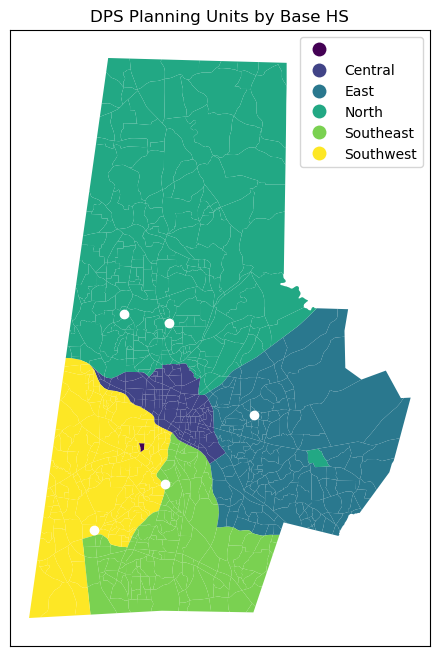

In [9]:
fig,ax = plt.subplots(figsize=(6,8))

dps_pu.plot(
    column = 'Region',
    legend = True,
    cmap = 'viridis',
    ax = ax
)
dps_base_hs.plot(ax=plt.gca(),zorder = 1, color = 'white')


ax.set_xticks([])
ax.set_yticks([])


plt.title('DPS Planning Units by Base HS')
plt.show()

In [10]:
hs_2028_geo = dps_pu.merge(hs_2028_full, on = 'pu_2324_84')[['pu_2324_84','X','Y','Region','Shape_Area','geometry','count','basez','lottery']]
#merge the student counts with the geometries
hs_2028_geo['centroid'] = hs_2028_geo['geometry'].centroid
hs_2028_geo.head()
#now we have the student counts and geometries for each planning unit

,pu_2324_84,X,Y,Region,Shape_Area,geometry,count,basez,lottery,centroid
0,1,2.049028e+06,893128.606346,North,3.556198e+07,"MULTIPOLYGON (((-8.77e+06 4.33e+06, -8.77e+06 ...",1.0,0.0,1.0,POINT (-8.78e+06 4.33e+06)
1,2,2.039923e+06,835434.121317,North,2.080136e+07,"MULTIPOLYGON (((-8.78e+06 4.31e+06, -8.78e+06 ...",9.0,4.0,4.0,POINT (-8.78e+06 4.31e+06)
2,3,2.058005e+06,797649.028742,East,1.329077e+07,"MULTIPOLYGON (((-8.77e+06 4.29e+06, -8.77e+06 ...",2.0,2.0,0.0,POINT (-8.77e+06 4.29e+06)
3,4,2.003222e+06,772895.737307,Southwest,4.684140e+07,"MULTIPOLYGON (((-8.79e+06 4.29e+06, -8.79e+06 ...",2.0,1.0,1.0,POINT (-8.79e+06 4.28e+06)
4,5,2.067334e+06,828244.230730,East,1.497046e+08,"MULTIPOLYGON (((-8.77e+06 4.3e+06, -8.77e+06 4...",8.0,6.0,1.0,POINT (-8.77e+06 4.3e+06)


<Axes: >

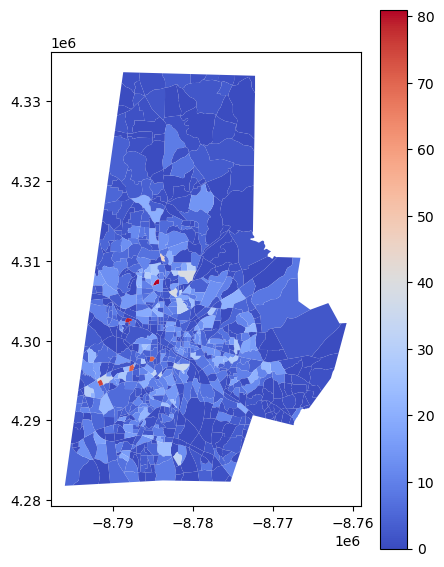

In [11]:
fig,ax = plt.subplots(figsize = (5,7))

hs_2028_geo.plot(
    column = 'basez',
    cmap = 'coolwarm',
    ax = ax,
    legend = True
)

In [12]:
#goal counts:
#Southern: 1700, Hillside: 1700, Northern: 1700, Riverside: 1700, Jordan: 2000

In [13]:
dps_base_hs = dps_base_hs[['name','geometry']]
dps_base_hs.loc[6,'name']='New High School'
dps_base_hs = dps_base_hs.reset_index()

C:\Users\olubl\AppData\Local\Temp\ipykernel_20264\1870785239.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dps_base_hs.loc[6,'name']='New High School'


In [15]:
#repeat until capacities in range
counts = pd.DataFrame([])
counts['capacity'] = [1700,1700,1700,1700,2000]
for i in range(0,10):
    counts['count']=[0,0,0,0,0]
    if i==0:
        counts['coefficient']=[1,1,1,1,1] 
    for pu in hs_2028_geo.index:
        centroid = hs_2028_geo.loc[pu,'centroid']
        num_students = hs_2028_geo.loc[pu,'count']
        [Southern, Hillside, Northern, Riverside, Jordan] = [dps_base_hs.loc[0,'geometry'].distance(centroid)*counts.loc[0,'coefficient'], 
                                                             dps_base_hs.loc[1,'geometry'].distance(centroid)*counts.loc[1,'coefficient'],
                                                             dps_base_hs.loc[2,'geometry'].distance(centroid)*counts.loc[2,'coefficient'],
                                                             dps_base_hs.loc[3,'geometry'].distance(centroid)*counts.loc[3,'coefficient'],
                                                             dps_base_hs.loc[4,'geometry'].distance(centroid)*counts.loc[4,'coefficient']]
        distances = {'Southern':Southern,
                     'Hillside':Hillside,
                     'Northern':Northern,
                     'Riverside':Riverside,
                     'Jordan':Jordan}
            
        assign = min(distances, key = distances.get)
        if assign == 'Southern':
            counts.loc[0,'count']+=num_students
        if assign == 'Hillside':
            counts.loc[1,'count']+=num_students
        if assign == 'Northern':
            counts.loc[2,'count']+=num_students
        if assign == 'Riverside':
            counts.loc[3,'count']+=num_students
        if assign == 'Jordan':
            counts.loc[4,'count']+=num_students
        hs_2028_geo.loc[pu,'assign']=assign


 
    #calculate coefficient outside for loop
    


<Axes: >

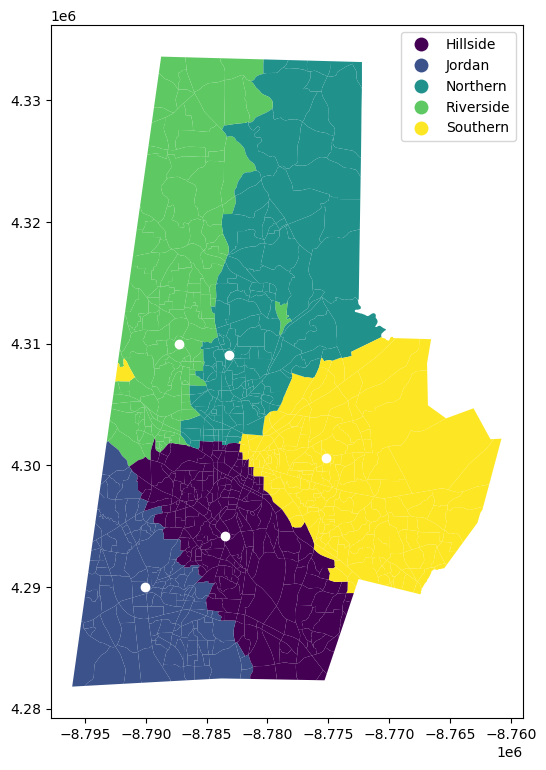

In [16]:
fig,ax = plt.subplots(figsize = (7,9))

hs_2028_geo.plot(
    column='assign',
    ax = ax,
    cmap = 'viridis',
    legend = True
)
dps_base_hs.plot(ax=plt.gca(), color = 'white')

In [34]:





for candidate in candidates.iterrows():
    dps_base_hs.loc[5,'geometry']=candidate['geometry'].centroid


    for i in range(0,10):
        assignment = []

        for pu in hs_2028_geo.iterrows():
            
            for j in range(0,6):
                distance_scores = centroid.distance(dps_base_hs.loc[j,'geometry'])*counts.loc(j,'coefficient')
                distances.append(distance_scores)
                
    hs_2028_geo['assign']=assign
        counts['coefficient'] *= (counts['count']/counts['capacity'])**0.3
#add column in hs_2028_geo with distance to school
objective=hs_2028_geo.merge(dps_base_hs,left_on='assign',right_on='name',how='left')
objective['distance']=objective['geometry_x'].distance(objective['geometry_y'])
objective_score = (objective['count']*objective['distance']).sum()

TypeError: Series.isin() takes 2 positional arguments but 4 were given

In [35]:
school_names = ['Southern High School','Hillside High School','Northern High School','Riverside High School','Jordan High School','New High School']
capacities = [1600,1810,1540,1540,1535,1600]

def score_candidate(candidate,hs_2028_geo,dps_base_hs,school_names,capacities):
    #centroids = hs_2028_geo['centroid']
    #num_students = hs_2028_geo['count']
    dps_base_hs.loc[5,'geometry']=candidate['geometry'].centroid
    
    counts = pd.DataFrame[{'school':school_names,
                           'capacity':capacities,
                           'count':[0],
                           'coefficient':[1]
                          }]                                 #initialize counts dataframe

    for i in range(10):                                      #iterative boundary assignment (running 10x)
        assignment = []
        for pu in hs_2028_geo.iterrows():                     #running through all planning units
            centroid = pu['centroids']
            distances = []
            for j in range(0,6):                               #collecting distance scores for all high schools
                distance_scores = centroid.distance(dps_base_hs.loc[j,'geometry'])*counts.loc(j,'coefficient')
                distances.append(distance_scores)
            assign = min(distances, key = distances.get)
            assignments.append(assign)                        #collect hs assignments based on min distance score
        hs_2028_geo['assign'] = assignments

        for i,school in enumerate(school_names):
            assigned_students = pu_geo.loc[pu_geo['assign'] == school, 'count'].sum()
            counts.loc[i, 'count'] = assigned_students                    #sum up counts for all high schools and update coefficients
        counts['coefficient'] *= (counts['count']/counts['capacity'])**0.3

    objective=hs_2028_geo.merge(dps_base_hs,left_on='assign',right_on='name',how='left')
    objective['distance']=objective['geometry_x'].distance(objective['geometry_y'])
    objective_score = (objective['count']*objective['distance']).sum()

    return objective_score

    

SyntaxError: invalid syntax (2895893515.py, line 27)

In [36]:
dps_pu.loc[62].apply(objective_score)

TypeError: 'numpy.float64' object is not callable

<Axes: >

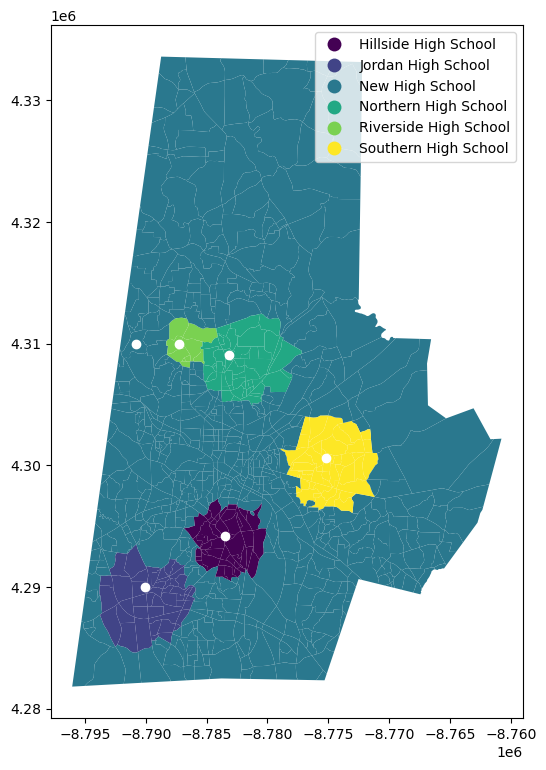

In [31]:
fig,ax = plt.subplots(figsize = (7,9))

hs_2028_geo.plot(
    column='assign',
    ax = ax,
    cmap = 'viridis',
    legend = True
)
dps_base_hs.plot(ax=plt.gca(), color = 'white')

In [33]:
dps_pu[dps_pu['Region']=='Southeast']

,OBJECTID,pu_2324_84,X,Y,M_min,PS_ID,PUID2122_2,ps_id_833,psid_982,TIMS_PU,Region,Shape_Length,Shape_Area,geometry
5,6,6,2.051484e+06,782851.159789,0.0,101,101,7,7,PU101,Southeast,21039.604030,2.494670e+07,"MULTIPOLYGON (((-8.77e+06 4.29e+06, -8.77e+06 ..."
6,7,7,2.028813e+06,773994.383954,0.0,704,704,8,8,PU704,Southeast,26778.407316,4.139709e+07,"MULTIPOLYGON (((-8.78e+06 4.29e+06, -8.78e+06 ..."
9,10,10,2.030285e+06,804148.584813,0.0,357,357,11,11,PU357,Southeast,13734.225776,9.234338e+06,"MULTIPOLYGON (((-8.78e+06 4.29e+06, -8.78e+06 ..."
33,34,34,2.030933e+06,812755.878663,0.0,820,820,40,40,PU820,Southeast,8816.879166,4.318160e+06,"MULTIPOLYGON (((-8.78e+06 4.3e+06, -8.78e+06 4..."
38,39,39,2.026659e+06,784539.200321,0.0,705,705,46,46,PU705,Southeast,8260.916212,3.243307e+06,"MULTIPOLYGON (((-8.78e+06 4.29e+06, -8.78e+06 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,803,803,2.022093e+06,782653.439962,0.0,706,706,47,47,PU706,Southeast,5800.872297,1.767752e+06,"MULTIPOLYGON (((-8.79e+06 4.29e+06, -8.79e+06 ..."
803,804,804,2.018289e+06,780939.459433,0.0,208,208,139,847,PU208,Southeast,6865.169093,2.457220e+06,"MULTIPOLYGON (((-8.79e+06 4.29e+06, -8.79e+06 ..."
822,823,823,2.030653e+06,811001.230029,0.0,820,820,40,40,PU820,Southeast,8117.056856,3.757582e+06,"MULTIPOLYGON (((-8.78e+06 4.3e+06, -8.78e+06 4..."
824,825,825,2.030118e+06,808247.984892,0.0,363,363,517,517,PU363,Southeast,6189.934116,2.083640e+06,"MULTIPOLYGON (((-8.78e+06 4.3e+06, -8.78e+06 4..."


In [ ]:
candidates = dps_pu[dps_pu['pu_2324_84'].isin([6,7,10])]


school_names = ['Southern High School','Hillside High School','Northern High School','Riverside High School','Jordan High School','New High School']
capacities = [1600,1810,1540,1540,1535,1600]
counts = pd.DataFrame[{}]

counts['count']=[0,0,0,0,0,0]

for candidate in candidate.iterrows():
    dps_base_hs.loc[5,'geometry']=candidate['geometry'].centroid
    for i in range(0,10):
        if i==0:
            counts['coefficient']=[1,1,1,1,1,1] 
        for pu in hs_2028_geo.index:
            centroid = hs_2028_geo.loc[pu,'centroid']
            num_students = hs_2028_geo.loc[pu,'count']
            [Southern, Hillside, Northern, Riverside, Jordan, New] = [dps_base_hs.loc[0,'geometry'].distance(centroid)*counts.loc[0,'coefficient'], 
                                                                      dps_base_hs.loc[1,'geometry'].distance(centroid)*counts.loc[1,'coefficient'],
                                                                      dps_base_hs.loc[2,'geometry'].distance(centroid)*counts.loc[2,'coefficient'],
                                                                      dps_base_hs.loc[3,'geometry'].distance(centroid)*counts.loc[3,'coefficient'],
                                                                      dps_base_hs.loc[4,'geometry'].distance(centroid)*counts.loc[4,'coefficient'],
                                                                      dps_base_hs.loc[5,'geometry'].distance(centroid)*counts.loc[5,'coefficient']]    
            distances = {'Southern High School':Southern,
                         'Hillside High School':Hillside,
                         'Northern High School':Northern,
                         'Riverside High School':Riverside,
                         'Jordan High School':Jordan,
                         'New High School':New}
                
            assign = min(distances, key = distances.get)
            if assign == 'Southern High School':
                counts.loc[0,'count']+=num_students
            if assign == 'Hillside High School':
                counts.loc[1,'count']+=num_students
            if assign == 'Northern High School':
                counts.loc[2,'count']+=num_students
            if assign == 'Riverside High School':
                counts.loc[3,'count']+=num_students
            if assign == 'Jordan High School':
                counts.loc[4,'count']+=num_students
            if assign == 'New High School':
                counts.loc[5,'count']+=num_students
            hs_2028_geo.loc[pu,'assign']=assign
        counts['coefficient'] *= (counts['count']/counts['capacity'])**0.3
#add column in hs_2028_geo with distance to school
objective=hs_2028_geo.merge(dps_base_hs,left_on='assign',right_on='name',how='left')
objective['distance']=objective['geometry_x'].distance(objective['geometry_y'])
objective_score = (objective['count']*objective['distance']).sum()